# Идентификация пользователей по посещенным веб-страницам

Ниже представлен пайплайн разработки алгоритма, который будет анализировать последовательность из нескольких веб-сайтов, посещенных подряд одним и тем же пользователем, и определять, Элис это или взломщик (кто-то другой). Более подробное описание задачи содержится в описании [соревнования](https://www.kaggle.com/c/catch-me-if-you-can-intruder-detection-through-webpage-session-tracking2/overview). 

**Ниже представлена навигация по основным пунктам пайплайна:**
* [Описание исходных данных](#Описание-исходных-данных)
* [Исследование исходных данных](#Исследование-исходных-данных)
* [Генерация дополнительных фичей](#Генерация-дополнительных-признаков)
* [Подбор модели и её параметров](#Выбор-модели-и-её-параметров)

# Описание исходных данных

[Исходные данные](https://www.kaggle.com/c/catch-me-if-you-can-intruder-detection-through-webpage-session-tracking2/data) содержат следующие файлы: 
* `train_sessions.csv`
* `test_sessions.csv`
* `site_dic.pkl`
* `train.zip`

`train_sessions.csv` и `test_sessions.csv` представляют собой сессии (последовательности посещённых пользователем сайтов) размером не более 10 сайтов и продолжительностью не более 30 минут. Сессии содержат следующие столбцы:
* site_i -- id j-го сайта, посещённого пользователем. Соответствие id-сайт представлено в словаре `site_dic.pkl`
* time_j -- время посещения соответствующего сайта
* target -- отметка сессий выполненных Alice (1-Alice, 0-noAlice)

Дополнительно в архиве `train.zip` представленны исходные данные, из которых формировались тренировочные сессии.

# Импорт библиотек и служебные функции

In [70]:
# ignore warnings
import warnings
warnings.filterwarnings('ignore')
# plotting lib's
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns
# sklearn
from sklearn.model_selection import TimeSeriesSplit, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.model_selection import validation_curve, learning_curve
from sklearn.metrics import roc_auc_score
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import accuracy_score , roc_curve, auc
from sklearn.linear_model import SGDClassifier, LogisticRegressionCV, LogisticRegression
from sklearn.svm import LinearSVC, SVC
# support
import pickle
import numpy as np
import pandas as pd
from scipy.sparse import hstack
import os
# does it need?
# from scipy.sparse import csr_matrix
# from __future__ import division, print_function
# from sklearn.metrics import confusion_matrix
# from sklearn.preprocessing import StandardScaler
# from sklearn.feature_extraction.text import TfidfTransformer
# from sklearn.model_selection import cross_val_predict, TimeSeriesSplit
# from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier

In [2]:
def write_to_submission_file(predicted_labels, out_file,
                             target='target', index_label="session_id"):
    predicted_df = pd.DataFrame(predicted_labels,
                                index = np.arange(1, predicted_labels.shape[0] + 1),
                                columns=[target])
    predicted_df.to_csv(out_file, index_label=index_label)

In [3]:
def plot_feature(train_feature, test_feature, target, xlim=None, bins=None):
    fig, axes = plt.subplots(2, 2, sharex=True, figsize=(16, 8))
    
    axes[0][0].set_title('Train dataset hist')
    axes[0][0].hist(train_feature, range=xlim, bins=bins, color='green')
    
    axes[1][0].set_title('Test dataset hist')
    axes[1][0].hist(test_feature, range=xlim, bins=bins, color='orange')
    
    axes[0][1].set_title('Alice hist')
    axes[0][1].hist(train_feature[target == 1], range=xlim, bins=bins, color='darkviolet')
    
    axes[1][1].set_title('Someone hist')
    axes[1][1].hist(train_feature[target == 0], range=xlim, bins=bins, color='grey')
    
    return fig, axes

In [51]:
def plot_validation_curves(param_values, grid_cv_results_):
    train_mu, train_std = grid_cv_results_['mean_train_score'], grid_cv_results_['std_train_score']
    valid_mu, valid_std = grid_cv_results_['mean_test_score'], grid_cv_results_['std_test_score']
    train_line = plt.plot(param_values, train_mu, '-', label='train', color='green')
    valid_line = plt.plot(param_values, valid_mu, '-', label='test', color='red')
    plt.fill_between(param_values, train_mu - train_std, train_mu + train_std, edgecolor='none',
                     facecolor=train_line[0].get_color(), alpha=0.2)
    plt.fill_between(param_values, valid_mu - valid_std, valid_mu + valid_std, edgecolor='none',
                     facecolor=valid_line[0].get_color(), alpha=0.2)
    plt.legend()

# Исследование исходных данных

**Загрузим исходные данные**

In [4]:
# path to data
PATH_TO_DATA = os.path.join('.', '..', 'data', 'kaggle')

In [5]:
# readind train and test datasets
time_columns = ['time%s' % i for i in range(1, 11)]
site_columns = ['site%s' % i for i in range(1, 11)]

train_df = pd.read_csv(os.path.join(PATH_TO_DATA, 'train_sessions.csv'),
                       index_col='session_id',
                       parse_dates=time_columns)
test_df = pd.read_csv(os.path.join(PATH_TO_DATA, 'test_sessions.csv'),
                      index_col='session_id',
                      parse_dates=time_columns)
# reading sites mapping
with open(os.path.join(PATH_TO_DATA, 'site_dic.pkl'), 'rb') as fo:
    site_dic = pickle.load(fo)

In [6]:
print('{} last session in train'.format(train_df['time1'].max()))
print('{} first session in test'.format(test_df['time1'].min()))

2014-04-30 23:39:53 last session in train
2014-05-01 17:14:03 first session in test


**Видно, что тренировочная и тестовая выборки разделены по времени, поэтому имеет смысл делить тренировочную выборку на обучение и валидацию также по времени. Для этого применим [TimeSeriesSplit](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html)**

In [7]:
# sort data
train_df = train_df.sort_values(by='time1')

In [8]:
train_df.head()

,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,...,time6,site7,time7,site8,time8,site9,time9,site10,time10,target
session_id,,,,,,,,,,,,,,,,,,,,,
21669,56,2013-01-12 08:05:57,55.0,2013-01-12 08:05:57,NaN,NaT,NaN,NaT,NaN,NaT,...,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,0
54843,56,2013-01-12 08:37:23,55.0,2013-01-12 08:37:23,56.0,2013-01-12 09:07:07,55.0,2013-01-12 09:07:09,NaN,NaT,...,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,0
77292,946,2013-01-12 08:50:13,946.0,2013-01-12 08:50:14,951.0,2013-01-12 08:50:15,946.0,2013-01-12 08:50:15,946.0,2013-01-12 08:50:16,...,2013-01-12 08:50:16,948.0,2013-01-12 08:50:16,784.0,2013-01-12 08:50:16,949.0,2013-01-12 08:50:17,946.0,2013-01-12 08:50:17,0
114021,945,2013-01-12 08:50:17,948.0,2013-01-12 08:50:17,949.0,2013-01-12 08:50:18,948.0,2013-01-12 08:50:18,945.0,2013-01-12 08:50:18,...,2013-01-12 08:50:18,947.0,2013-01-12 08:50:19,945.0,2013-01-12 08:50:19,946.0,2013-01-12 08:50:19,946.0,2013-01-12 08:50:20,0
146670,947,2013-01-12 08:50:20,950.0,2013-01-12 08:50:20,948.0,2013-01-12 08:50:20,947.0,2013-01-12 08:50:21,950.0,2013-01-12 08:50:21,...,2013-01-12 08:50:21,946.0,2013-01-12 08:50:21,951.0,2013-01-12 08:50:22,946.0,2013-01-12 08:50:22,947.0,2013-01-12 08:50:22,0


**Краткая сводка по данным**

253561 sessions in train dataset
82797 sessions in test dataset
48371 unique sites over all sessions


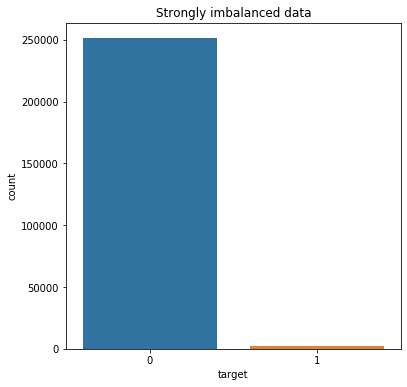

In [9]:
print('{} sessions in train dataset'.format(len(train_df)))
print('{} sessions in test dataset'.format(len(test_df)))
print('{} unique sites over all sessions'.format(len(site_dic)))

fig, axes = plt.subplots(1, 1, figsize=(6, 6))
sns.countplot(train_df.target, ax=axes)
axes.set_title('Strongly imbalanced data')
pass

**Проверим сохраниться ли отношение классов при делении на обучающую и валидационную выборки**

In [10]:
tscv = TimeSeriesSplit(n_splits=10)
for train_index, valid_index in tscv.split(train_df):
    train_ratio = (train_df.iloc[train_index, -1] == 1).sum() / (train_df.iloc[train_index, -1] == 0).sum()
    tvalid_ratio = (train_df.iloc[valid_index, -1] == 1).sum() / (train_df.iloc[valid_index, -1] == 0).sum()
    print('train ratio {:.3f} against valid ratio {:.3f}'.format(train_ratio, tvalid_ratio))

train ratio 0.021 against valid ratio 0.013
train ratio 0.017 against valid ratio 0.012
train ratio 0.016 against valid ratio 0.005
train ratio 0.013 against valid ratio 0.001
train ratio 0.010 against valid ratio 0.009
train ratio 0.010 against valid ratio 0.008
train ratio 0.010 against valid ratio 0.001
train ratio 0.009 against valid ratio 0.016
train ratio 0.010 against valid ratio 0.003
train ratio 0.009 against valid ratio 0.012


**Сделаем колонки посещённых сайтов типа `int` и заполним пропуски нулями**

In [11]:
train_df[site_columns] = train_df[site_columns].fillna(0).astype('int')
test_df[site_columns] = test_df[site_columns].fillna(0).astype('int')

<a id='site_freq'></a>
**Посчитаем частоты встречаемости сайтов в сессиях**

In [12]:
train_freq = pd.Series(train_df[site_columns].values.flatten()).value_counts()
train_alice_freq = pd.Series(train_df[train_df.target==1][site_columns].values.flatten()).value_counts()
test_freq = pd.Series(test_df[site_columns].values.flatten()).value_counts()

site_freq = pd.DataFrame(np.zeros((len(site_dic), 5), dtype=int))
site_freq.iloc[:, 0] = site_dic.keys()
site_freq.index = np.array(list(site_dic.values()), dtype=int)
site_freq.columns = ['site', 'train_count', 'test_count', 
                     'train_alice_count', 'train_noalice_count']

for key, val in site_dic.items():
    try:
        site_freq['train_count'].loc[val] = train_freq[val]
    except:
        pass
    try:
        site_freq['train_alice_count'].loc[val] = train_alice_freq[val]
    except:
        pass
    try:
        site_freq['test_count'].loc[val] = test_freq[val]
    except:
        pass
    
site_freq['train_noalice_count'] = site_freq['train_count'] - site_freq['train_alice_count']

In [13]:
site_freq.sort_values('train_count', ascending=False).head(15)

,site,train_count,test_count,train_alice_count,train_noalice_count
21,www.google.fr,123776,37175,857,122919
23,www.google.com,87619,24243,437,87182
782,annotathon.org,77055,31755,0,77055
22,apis.google.com,58258,17655,522,57736
29,www.facebook.com,54094,19580,897,53197
167,www.bing.com,46405,15293,50,46355
780,blast.ncbi.nlm.nih.gov,43841,7511,0,43841
778,www.ncbi.nlm.nih.gov,38194,25813,0,38194
52,clients1.google.com,36085,10338,206,35879
812,mail.google.com,35178,10130,0,35178


In [14]:
site_freq.sort_values('test_count', ascending=False).head(15)

,site,train_count,test_count,train_alice_count,train_noalice_count
21,www.google.fr,123776,37175,857,122919
782,annotathon.org,77055,31755,0,77055
778,www.ncbi.nlm.nih.gov,38194,25813,0,38194
23,www.google.com,87619,24243,437,87182
1202,claroline.univ-bpclermont.fr,1677,20413,0,1677
29,www.facebook.com,54094,19580,897,53197
22,apis.google.com,58258,17655,522,57736
167,www.bing.com,46405,15293,50,46355
80,s.youtube.com,31391,14261,1354,30037
302,ent.univ-bpclermont.fr,3656,11100,0,3656


**Видно, что рейтинг встречаемости сайтов в тренировочной и тестовой хоть и достаточно близки но различаются**

**Также можно отметить, что только половина самых популярных сайтов посещалось самой Alice. Этот факт стоит учесть при составлении дополнительных признаков.**

# Генерация пристранства признаков

**Данная глава делится на несколько подразделов:**
* [Формирование основного пространства признаков](#Преобразование-последовательностей-посещённых-сайтов)
* [Формирование дополнительных временных признаков](#Формирование-временных-признаков)
* [Формирование дополнительных признаков, основанных на особенностях последовательности посещений сайтов](#Формирование-признаков-основанных-на-последовательностях-сайтов)
* [Итоговый анализ сформированных признаков](#Общий-анализ-признаков)

## Преобразование последовательностей посещённых сайтов

**Для начала вопользуемся предположением о том, что последовательность посещённых сайтов не так важна, как сами сайты сессии. Тогда можем преобразовать последовательности сайтов сессии с помощью CountVectorizer**

**Для этого переведём данные в подходящий для CountVectorizer вид**

In [15]:
train_df[site_columns].to_csv('train_sessions_text.txt', 
                              sep=' ', index=None, header=None)
test_df[site_columns].to_csv('test_sessions_text.txt', 
                             sep=' ', index=None, header=None)

In [16]:
!head -5 train_sessions_text.txt

56 55 0 0 0 0 0 0 0 0
56 55 56 55 0 0 0 0 0 0
946 946 951 946 946 945 948 784 949 946
945 948 949 948 945 946 947 945 946 946
947 950 948 947 950 952 946 951 946 947


**Применим CountVectorizer. При этом будем искать би- и три-граммы (для некоторого учёта последовательности сайтов) и ограничим пространство признаков 50000 (из соображений, что изначально имели около 50000 уникальных сайтов)**

In [97]:
%%time
cv = CountVectorizer(ngram_range=(1, 3), max_features=50000)
with open('train_sessions_text.txt') as inp_train_file:
    X_train_full = cv.fit_transform(inp_train_file)
with open('test_sessions_text.txt') as inp_test_file:
    X_test = cv.transform(inp_test_file)
X_train_full.shape, X_test.shape

CPU times: user 7.52 s, sys: 49.1 ms, total: 7.56 s
Wall time: 7.56 s


((253561, 50000), (82797, 50000))

**Также запишем отдельно вектор целевой переменной**

In [18]:
y_train_full = train_df.target.astype('int')

## Формирование временных признаков

**В этой части будут проанализрованы признаки, временных характеристиках сессии**

**Добавим в исходные данные время посещения каждого сайта в сессии**

In [19]:
%%time
for i in range(1, len(time_columns)):
    col1 = time_columns[i - 1]
    col2 = time_columns[i]
    
    dt = (train_df[col2] - train_df[col1]).apply(lambda x: x.total_seconds()).fillna(0).astype('int').to_numpy()
    train_df['time_diff{}'.format(i)] = dt
    
    dt = (test_df[col2] - test_df[col1]).apply(lambda x: x.total_seconds()).fillna(0).astype('int').to_numpy()
    test_df['time_diff{}'.format(i)] = dt
    
time_diff_columns = ['time_diff{}'.format(i) for i in range(1, 10)]

CPU times: user 18.7 s, sys: 6.53 ms, total: 18.7 s
Wall time: 18.7 s


**Обратим внимание на признаки:**
* день недели начала сессии
* час начала сессии

In [20]:
def calc_week_day(df):
    ext_feature = df['time1'].apply(lambda x: x.dayofweek).to_numpy()
    
    return ext_feature

def calc_start_hour(df):
    ext_feature = df['time1'].apply(lambda x: x.hour).to_numpy()
    
    return ext_feature

day of week


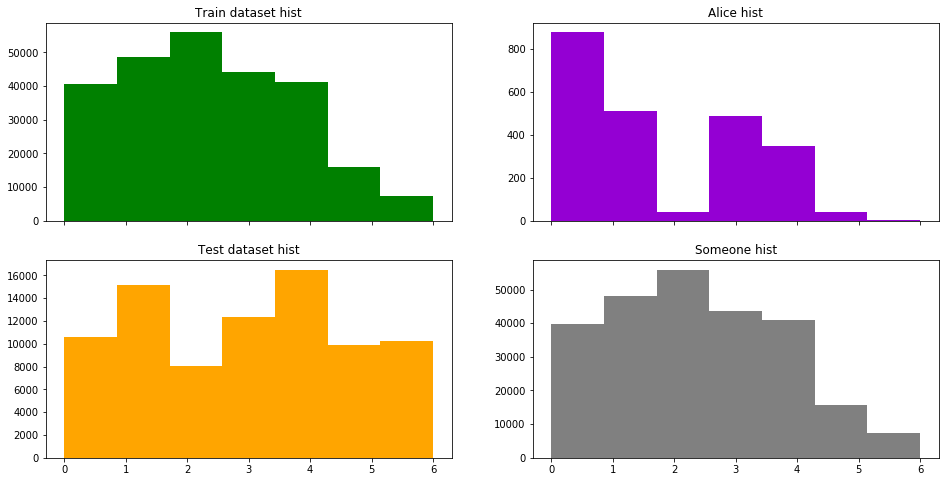

In [21]:
print('day of week')
train_day_of_week = calc_week_day(train_df)
test_day_of_week = calc_week_day(test_df)
plot_feature(train_day_of_week, test_day_of_week, y_train_full, bins=7);

**Видно, что поведение целевого пользователя существенно отличается от остальных. Тем не менее, распределение данного признака на обучении и тесте тоже различно, поэтому следует применять этот признак с осторожностью.**

In [22]:
def form_day_of_week_feature(df):
    day_of_week = calc_week_day(df)
    feature = pd.DataFrame(np.zeros((len(df), 7), dtype=int))
    feature.columns = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
    
    for t in np.unique(day_of_week):
        feature.iloc[:, t] = (day_of_week == t)
    
    return feature.astype('int')

session start hour


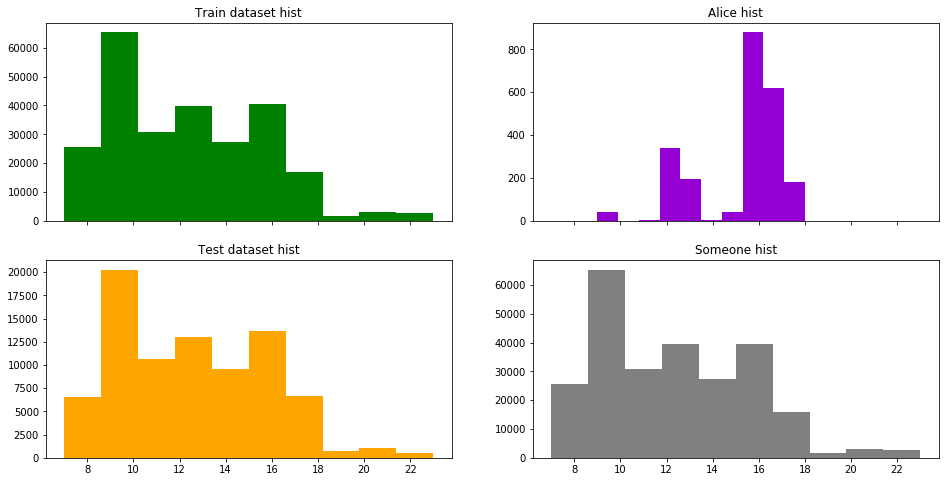

In [23]:
print('session start hour')
train_start = calc_start_hour(train_df)
test_start = calc_start_hour(test_df)
plot_feature(train_start, test_start, y_train_full);

**Распределения на обучающей и тестовой выборке схожи и почедение Alice заметно отличается от большинства. Для формирования признака разделим день на 5 частей [0, 6], [7, 10], [11, 14], [15, 18], [19, 23]**

In [24]:
def form_start_hour_feature(df):
    hour_range = [-1, 6, 10, 14, 18, 23]
    start_hour = calc_start_hour(df)
    
    ext_feature = np.zeros((len(start_hour), 5), dtype=int)
    i = 0
    for start, end in zip(hour_range[:-1], hour_range[1:]):
        index = np.logical_and(start_hour > start, start_hour <= end)
        ext_feature[index, i] = 1
        i += 1
        
    day_of_week = calc_week_day(df)
    feature = pd.DataFrame(ext_feature)
    feature.columns = ['{} day part'.format(i) for i in range(5)]
    
    return feature

**Также из временных признаков были проанализированы продолжительности сессий. Но найти характерного отличия Alice от остальных пользователей найти не удалось**

**Также обратившись к таблице можем заметить, что Alice любит посмотреть youtube, поэтому можем проанализировать признак "длительность посещения youtube в минутах"**

In [25]:
def calc_youtube_duration(df):
    duration = np.zeros((len(df),), dtype=int)
    
    sites = df[site_columns].to_numpy()
    dtimes = df[time_diff_columns].to_numpy()
    youtube_idxs = [site_dic[key] for key in site_dic.keys() if key.find('youtube') > -1]
    
    for idx in youtube_idxs:
        for i in range(9):
            indices = sites[:, i] == idx
            duration[indices] += np.array(list(map(lambda x: int(np.round(x)), (dtimes[indices, i] / 60))), dtype=int)
    
    return duration

youtube duration per session in minutes


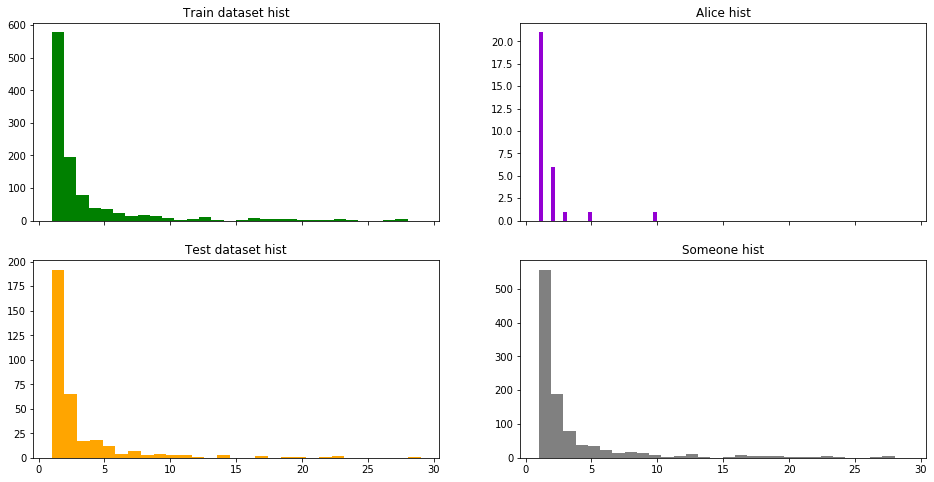

In [26]:
print('youtube duration per session in minutes')
train_duration = calc_youtube_duration(train_df)
test_duration = calc_youtube_duration(test_df)
train_indices = train_duration > 0
test_indices = test_duration > 0
plot_feature(train_duration[train_indices], test_duration[test_indices], y_train_full[train_indices], bins=29);

**Видно, что продолжительность посещений youtube целевым пользователем не привышает 10 минут. Тогда можем ввести ещё 1 временной признак:**

In [27]:
def form_youtube_duration_feature(df):
    duration = calc_youtube_duration(df)
    
    ext_feature = np.zeros((len(duration), 1), dtype=int)
    
    index = duration <= 10
    ext_feature[index, 0] = 1
    
    feature = pd.DataFrame(ext_feature)
    feature.columns = ['youtube duration']
    
    return feature

## Формирование признаков основанных на последовательностях сайтов

**В данной части будут рассмотрены признаки, основанные на характеристиках сессий, связанных с последовательностью посещённых сайтов (безотносительно ко времени посещения)**

**Посмотрим на количество уникальных сайтов в сессии**

In [28]:
def calc_unique(df):
    ext_feature = df[site_columns].nunique(axis=1)

    return ext_feature

unique sites


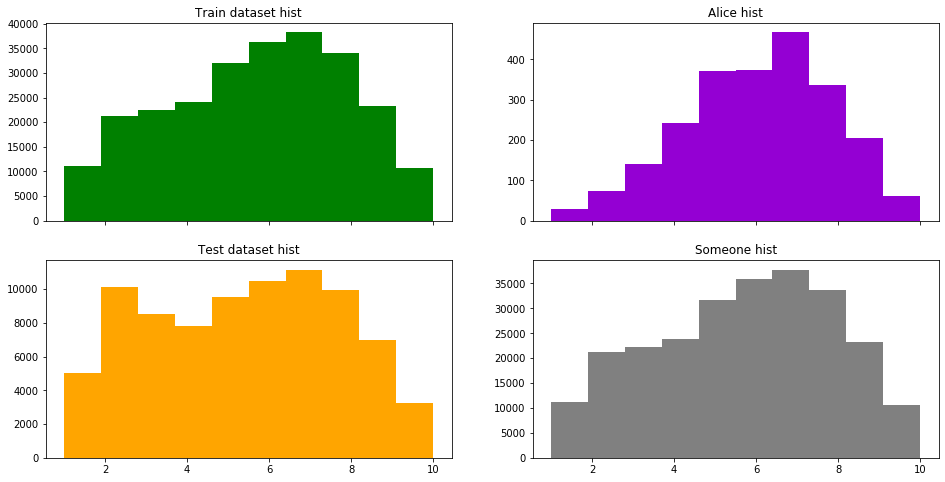

In [29]:
print('unique sites')
train_unique = calc_unique(train_df)
test_unique = calc_unique(test_df)
plot_feature(train_unique, test_unique, y_train_full, bins=10);

**Визуально распределение тестовой выборки отличается от тренировочной больше, чем распределение Alice от остальных полльзователей. Не берём этот признак в расчёт.**

**Рассмотрим количества в сессии сайтов из топ-30**

In [30]:
def calc_top_count(df, top=10, column='train_count'):
    top_ids = list(site_freq.sort_values(column, ascending=False).index[:top])
    ext_feature = np.zeros((len(df), ))
    
    for site_id in top_ids:
        ext_feature += df[site_columns].apply(lambda x: x==site_id).sum(axis=1)

    return ext_feature

count top 30 sites


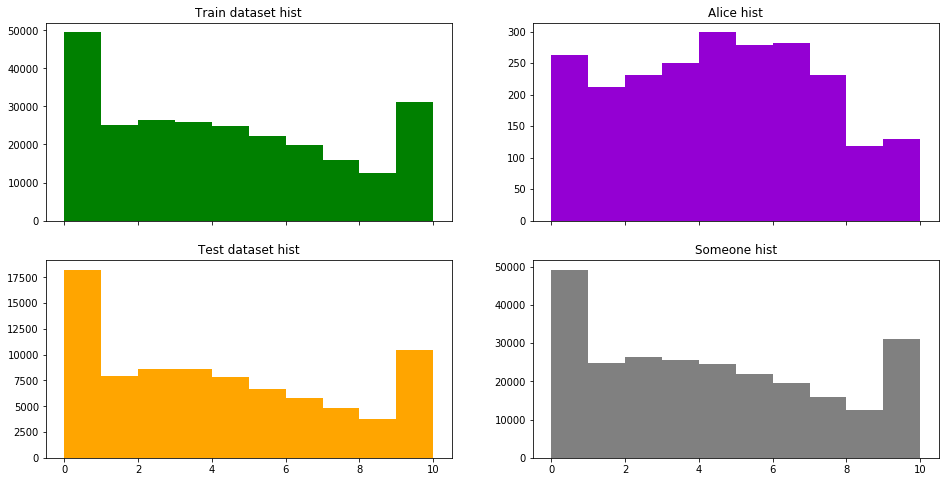

In [31]:
print('count top 30 sites')
train_top30 = calc_top_count(train_df, top=30)
test_top30 = calc_top_count(test_df, top=30)
plot_feature(train_top30, test_top30, y_train_full);

**Видим, что распределения не тенировочном и тестовом датасетах совпадают, при этом распределение Alice несколько отличается от остальных пользователей.**

**Тем не менее, видим, что лучше брать топ посещённых именно Alice сайтов.**

count top 30 Alice sites


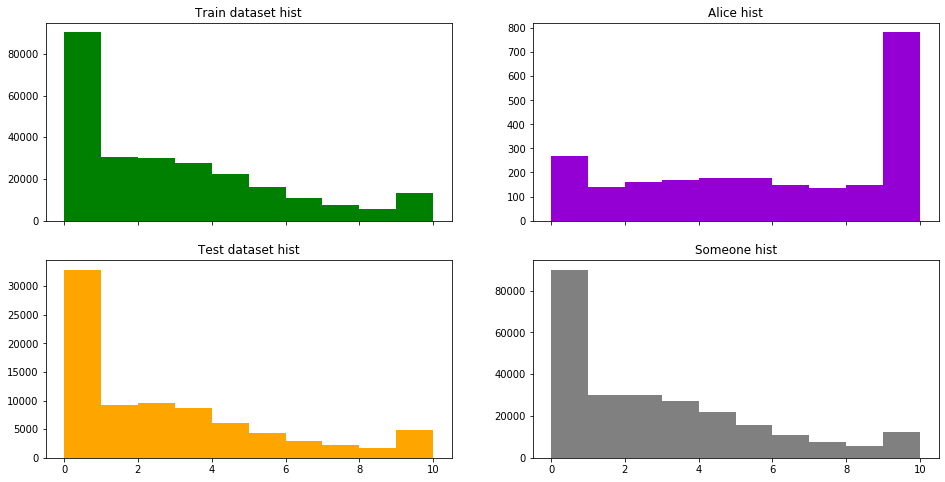

In [32]:
print('count top 30 Alice sites')
train_top30 = calc_top_count(train_df, top=30, column='train_alice_count')
test_top30 = calc_top_count(test_df, top=30, column='train_alice_count')
plot_feature(train_top30, test_top30, y_train_full);

In [33]:
def form_top30_feature(df):
    ext_feature = calc_top_count(df, top=30, column='train_alice_count')
    
    feature = pd.DataFrame(ext_feature)
    feature.columns = ['top30']
    return feature

**При исследовании [списка самых посещаемых сайтов](#site_freq) было отмечено, что существенная часть сайтов из топа рейтига не посещалась Alice вовсе. Исходя из этого можно сформировать признак, учитывающий данный факт.**

In [34]:
def calc_top_worst_visit(df, top=10):
    top_site_freq = site_freq.sort_values('train_count', ascending=False).iloc[:top, :]
    worst_ids = list(top_site_freq.sort_values('train_alice_count', ascending=True).index[:int(top / 2)])
    ext_feature = np.zeros((len(df), ))
    
    for site_id in worst_ids:
        ext_feature += df[site_columns].apply(lambda x: x==site_id).sum(axis=1)

    return np.array(ext_feature > 0, dtype=int)

count 10 worst for Alice sites


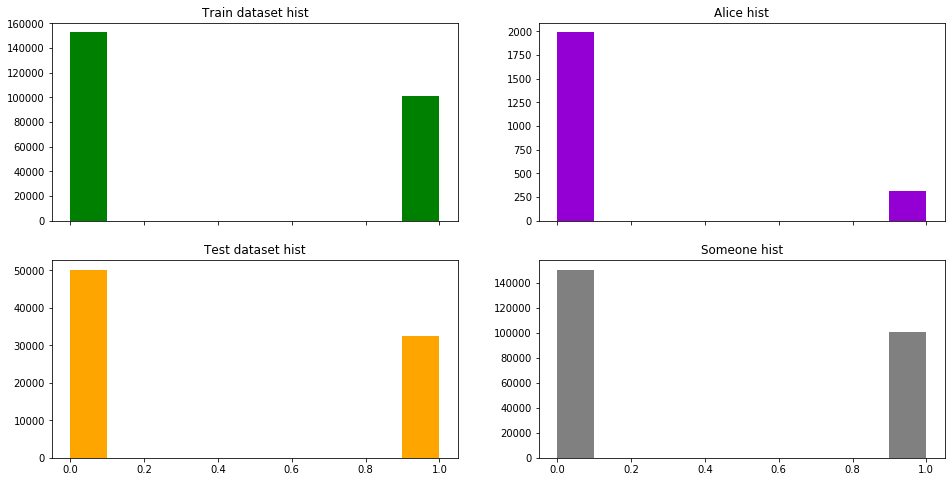

In [35]:
print('count 10 worst for Alice sites')
train_worst10 = calc_top_worst_visit(train_df, top=20)
test_worst10 = calc_top_worst_visit(test_df, top=20)
plot_feature(train_worst10, test_worst10, y_train_full);

**Возьмём этот признак на вооружение**

In [36]:
def form_worst10_feature(df):
    ext_feature = calc_top_worst_visit(train_df, top=20)
    
    feature = pd.DataFrame(ext_feature)
    feature.columns = ['worst 10 of top 20']
    
    return feature

**Также попробуем посмотреть на частоты посещений отдельных сайтов (таких как facebook и twitter)**

In [37]:
def calc_facebook_count(df):
    counter = np.zeros((len(df),), dtype=int)
    
    sites = df[site_columns].to_numpy()
    facebook_idxs = [site_dic[key] for key in site_dic.keys() if key.find('facebook') > -1]
    
    for idx in facebook_idxs:
        for i in range(9):
            indices = sites[:, i] == idx
            counter[indices] += 1
    
    return counter

facebook visits per session


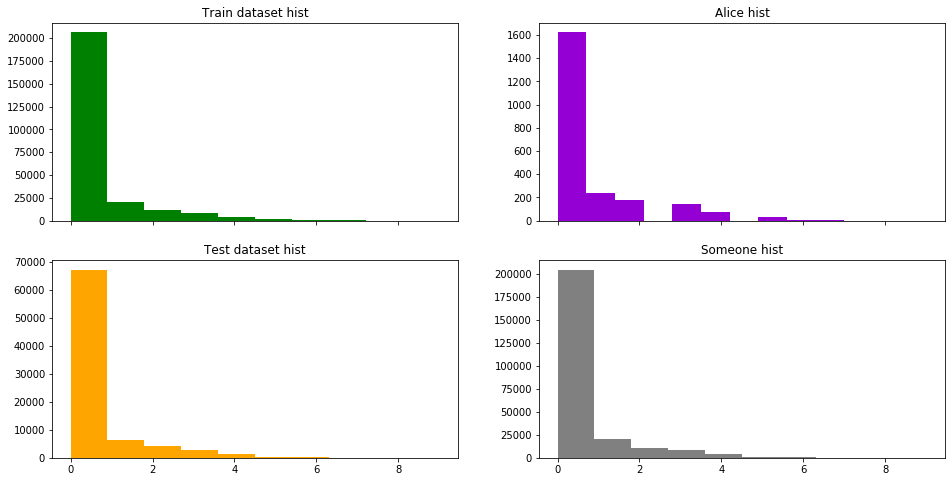

In [38]:
print('facebook visits per session')
train_facebook = calc_facebook_count(train_df)
test_facebook = calc_facebook_count(test_df)
plot_feature(train_facebook, test_facebook, y_train_full, bins=10);

In [39]:
def calc_twitter_count(df):
    counter = np.zeros((len(df),), dtype=int)
    
    sites = df[site_columns].to_numpy()
    twitter_idxs = [site_dic[key] for key in site_dic.keys() if key.find('twitter') > -1]
    
    for idx in twitter_idxs:
        for i in range(9):
            indices = sites[:, i] == idx
            counter[indices] += 1
    
    return counter

twitter visits per session


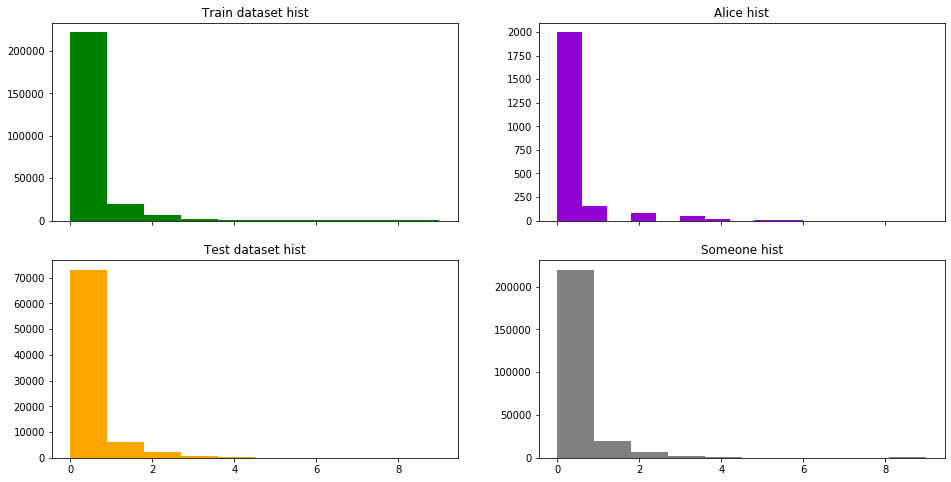

In [40]:
print('twitter visits per session')
train_twitter = calc_twitter_count(train_df)
test_twitter = calc_twitter_count(test_df)
plot_feature(train_twitter, test_twitter, y_train_full, bins=10);

**Пока добавим к признакам, так как видно, что Alice сидит в facebook и twitter чуть чаще, чем основная масса пользователей**

In [41]:
def form_facebook_feature(df):
    ext_feature = calc_facebook_count(train_df)
    
    feature = pd.DataFrame(ext_feature)
    feature.columns = ['facebook count']
    
    return feature

def form_twitter_feature(df):
    ext_feature = calc_twitter_count(train_df)
    
    feature = pd.DataFrame(ext_feature)
    feature.columns = ['twitter count']
    
    return feature

## Общий анализ признаков

In [42]:
additional_features = form_day_of_week_feature(train_df)
additional_features = additional_features.join(form_start_hour_feature(train_df))
additional_features = additional_features.join(form_youtube_duration_feature(train_df))
additional_features = additional_features.join(form_top30_feature(train_df))
additional_features['top30'] = additional_features['top30'].fillna(0).astype('int')
additional_features = additional_features.join(form_worst10_feature(train_df))
additional_features = additional_features.join(form_facebook_feature(train_df))
additional_features = additional_features.join(form_twitter_feature(train_df))

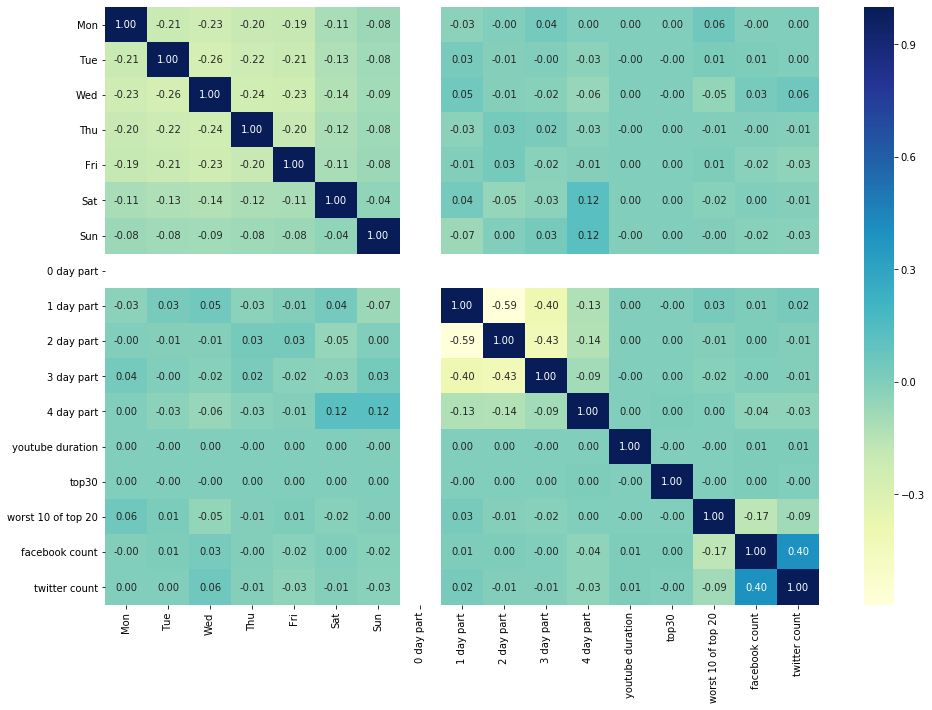

In [43]:
corr = additional_features.corr('spearman') 
plt.figure(figsize = ( 16 , 11 )) 
sns.heatmap(corr,annot=True,fmt='.2f',cmap="YlGnBu");

**Видно, что явно скоррелированных между собой признаков нет.**

In [98]:
X_train_full = hstack([X_train_full, additional_features.to_numpy()])

In [46]:
additional_features_test = form_day_of_week_feature(test_df)
additional_features_test = additional_features_test.join(form_start_hour_feature(test_df))
additional_features_test = additional_features_test.join(form_youtube_duration_feature(test_df))
additional_features_test = additional_features_test.join(form_top30_feature(test_df))
additional_features_test['top30'] = additional_features_test['top30'].fillna(0).astype('int')
additional_features_test = additional_features_test.join(form_worst10_feature(test_df))
additional_features_test = additional_features_test.join(form_facebook_feature(test_df))
additional_features_test = additional_features_test.join(form_twitter_feature(test_df))

In [99]:
X_test = hstack([X_test, additional_features_test.to_numpy()])

# Выбор модели и её параметров

**Сперва попробуем поподбирать параметры логистической регрессии**

In [100]:
tscv = TimeSeriesSplit(n_splits=10)

In [101]:
logit = LogisticRegression(random_state=17)

In [104]:
%%time
param_grid = {
    'C': np.linspace(0.1, 1, 20),
    'solver': ['lbfgs', 'liblinear'],
    'class_weight': [None, 'balanced']
}

logit_grid_searcher = GridSearchCV(logit, param_grid=param_grid, 
                                   n_jobs=-1, cv=tscv, return_train_score=True, scoring='roc_auc')
logit_grid_searcher.fit(X_train_full, y_train_full)

CPU times: user 8.17 s, sys: 6.45 s, total: 14.6 s
Wall time: 14min 40s


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=10),
             error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=17, solver='warn',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn'...
             param_grid={'C': array([0.1       , 0.14736842, 0.19473684, 0.24210526, 0.28947368,
       0.33684211, 0.38421053, 0.43157895, 0.47894737, 0.52631579,
       0.57368421, 0.62105263, 0.66842105, 0.71578947, 0.76315789,
       0.81052632, 0.85789474, 0.90526316, 0.95263158, 1.       

In [105]:
print('best score is {:.3f} correspond to {}'.format(logit_grid_searcher.best_score_, logit_grid_searcher.best_params_))

best score is 0.898 correspond to {'C': 0.7157894736842105, 'class_weight': None, 'solver': 'lbfgs'}


**Попробуем также линейный SVM**

In [106]:
svm = LinearSVC(random_state=17)

In [107]:
%%time
param_grid = {
    'C': np.logspace(-4, 0, 20),
    'loss': ['hinge', 'squared_hinge'],
    'class_weight': [None, 'balanced']
}

svm_grid_searcher = GridSearchCV(svm, param_grid=param_grid, 
                                  n_jobs=-1, cv=tscv, return_train_score=True, scoring='roc_auc')
svm_grid_searcher.fit(X_train_full, y_train_full)

CPU times: user 11.7 s, sys: 1.03 s, total: 12.7 s
Wall time: 8min 50s


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=10),
             error_score='raise-deprecating',
             estimator=LinearSVC(C=1.0, class_weight=None, dual=True,
                                 fit_intercept=True, intercept_scaling=1,
                                 loss='squared_hinge', max_iter=1000,
                                 multi_class='ovr', penalty='l2',
                                 random_state=17, tol=0.0001, verbose=0),
             iid='warn', n_jobs=-1,
             param_grid={'C': array([1.00000000e-...
       6.95192796e-04, 1.12883789e-03, 1.83298071e-03, 2.97635144e-03,
       4.83293024e-03, 7.84759970e-03, 1.27427499e-02, 2.06913808e-02,
       3.35981829e-02, 5.45559478e-02, 8.85866790e-02, 1.43844989e-01,
       2.33572147e-01, 3.79269019e-01, 6.15848211e-01, 1.00000000e+00]),
                         'class_weight': [None, 'balanced'],
                         'loss': ['hinge', 'squared_hinge']},
             pre_dispatch='2*n_jobs

In [108]:
print('best score is {:.3f} correspond to {}'.format(svm_grid_searcher.best_score_, svm_grid_searcher.best_params_))

best score is 0.897 correspond to {'C': 0.0011288378916846883, 'class_weight': 'balanced', 'loss': 'squared_hinge'}


**Логистическая регрессия несколько лучше**

In [109]:
best_logit = logit_grid_searcher.best_estimator_

In [110]:
best_logit.fit(X_train_full, y_train_full)

LogisticRegression(C=0.7157894736842105, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=17, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [111]:
y_proba = best_logit.predict_proba(X_test)

In [112]:
write_to_submission_file(y_proba[:, 1], './answers/final_submission.csv')

**В итоге получилось меньше, чем просто первыми тыканиями)**